# Diving Deeper into DeepDream

A few weeks ago, Google released it's Deep Dream source code. Suddenly interest in machine learning exploded, and artists especially were interested in seeing what the Deep Dream software could do with their own artwork.

I've been working with Deep Learning and Theano at work for the past few months, training on audio data, and doing some deep learning to tell some audio apart.

In diving into machine learning, I've noticed that the overwhelming majority of work happens in getting data ready, forming hypothesis on your data, and that choosing an algorithm is really a very small piece of the total work.

So I wanted to walk through the Deep Dream source code, and talk about how it works, beyond just the loading of the GoogleNet, in the hopes that you'll walk away with a better idea for how to load and use images, to ready them for processing, and to feel confident enough to begin making your own data sets, and creating Deep Dream videos by hand.

In [6]:
from cStringIO import StringIO          #     Used to save and display the image in the IPython notebook 
                                        #      as its generated, used only in showarray()

import numpy as np                      #     Used to do all the matrix math, with the exception of the zoom

import scipy.ndimage as nd              #     Used to do just the zoom on the images, as we go up the sizes (octaves)
import PIL.Image                        #     Used to load images from file, and to save manipulated images back to 
                                        #     files

from IPython.display import clear_output, Image, display
                                        #     Used to display the images as the neural runs over iterations

from google.protobuf import text_format #     Inter language data format for our blobs. A way to save and load trained
                                        #     networks in Caffe. Only used to add our 

import caffe                            #     The machine learning framework upon which everything works.

#caffe.set_mode_gpu()                   #     Uncomment to put computation on GPU. You'll need caffe built with 
                                        #     CuDNN and CUDA, and an NVIDIA card

def showarray(a, fmt='jpeg'):           #     IPython helper used to show images in progress
    
    a = np.uint8(np.clip(a, 0, 255))    #     Convert and clip our matrix into the jpeg constraints (0-255 values
                                        #     for Red, Green, Blue)
        
    f = StringIO()                      #     Our string file handler
    PIL.Image.fromarray(a).save(f, fmt) #     Rather than saving to a file each time, save to our string handler
    display(Image(data=f.getvalue()))   #     Display the image in our notebook, using the IPython.display, and 
                                        #     IPython.Image helpers.

## Loading the Neural Network

The deep dream code only shows how to load one neural network, and it's left up to the user to download and install the other networks. I've successfully installed the [GoogleNet Places dataset](http://places.csail.mit.edu/downloadCNN.html) from MIT, with the caveat that I had to use the GoogleNet trained version at the bottom of the MIT page.

In [51]:
model_path = '../caffe/models/googlenet_places205/' # path to your neural network model. feel free to download other
                                                    # models and play with them from the model zoo at caffe.

net_fn   = model_path + 'deploy_places205.protxt'   # specifies the neural network's layers and their arrangement
                                                    # we load this and patch it to add the force backward below

param_fn = model_path + 'googlelet_places205_train_iter_2400000.caffemodel'

# Patching model to be able to compute gradients.
# Note that you can also manually add "force_backward: true" line to "deploy.prototxt".

# In other words, we've included text_format from google.protobuf above just so that we can
# add this single line to the file. If you manually add the line to the prototxt, (or in this
# case, the misspelled protxt included in MIT's set, you'll be able to get rid of the dependency
# on protobuf.

model = caffe.io.caffe_pb2.NetParameter()           # Load the empty protobuf model,
text_format.Merge(open(net_fn).read(), model)       # Load the prototxt and load it into empty model
model.force_backward = True                         # Add the force_backward: true line
open('tmp.prototxt', 'w').write(str(model))         # Save it to a new file called tmp.prototxt

net = caffe.Classifier('tmp.prototxt', param_fn,    # Load the neural network. Using the prototxt from above
                       mean = np.float32([104.0, 116.0, 122.0]), # ImageNet mean, training set dependent
                       channel_swap = (2,1,0))      # the reference model has channels in BGR order instead of RGB

# The above code loads up our neural network, but there a few interesting things to note. 

# -> param_fn - our trained neural network blob

# -> mean - the RGB average of our images. we will later subtract and then add this back to our model.
#           interesting changes can be made by changing these numbers, and for the places dataset, the
#           numbers above are actually wrong. I couldn't find the proper mean for it.

# -> channel_swap - different order of values, with Blue, Green and Red as the matrix order. switches it
#                   to Red, Green, Blue
 
# a couple of utility functions for converting to and from Caffe's input image layout
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']

# Now this function above is a doozie. Don't let its shortness deceive you, it's doing a lot.
# net.transformer.mean['data'] is our image mean we discussed above. it's being subtracted from
# np.float32(np.rollaxis(img, 2)[::-1]). This function warrants a discussion about numpy. I'll 
# dive deeper into it below.

def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])

# This function does the reverse of preprocess, and I'll go over how it works below too. But 
# both these functions warrant talking about how they work.

def preprocesswithoutmean(img):
    return np.float32(np.rollaxis(img, 2)[::-1])

def deprocesswithoutmean(img):
    return np.dstack(img[::-1])

## A Digression, or how images work in Numpy and PIL

The two above helper functions have some interesting things going on that warrant a discussion. Google's comment says functions for converting to and from Caffe's input image format.

Why would caffe not just use JPEG image formats? And why would we need to rollaxis, and what does [::-1] do in Python?

Well, let's open up iPython and find out.

In [22]:
exploring = np.float32(PIL.Image.open('numpyexample.jpg'))
showarray(exploring)

The above image is a 25 x 25 jpeg with a simple gradient. We're going to use it to understand the transformations that occur when we do our image processing.

In [9]:
exploring.shape

(25, 25, 3)

In [10]:
exploring[0][0]

array([ 251.,    2.,    0.], dtype=float32)

The above two statements tell us a bit about how images work in general. They're just arrays of Red, Green and Blue values. In this example, we have an x and y coordinates, with values for Red, Green, and Blue contained in the last array. 

So what is it the preprocess() function above is doign in that np.rollaxis? Let's find out:

In [11]:
np.rollaxis(exploring, 2).shape

(3, 25, 25)

In [12]:
np.rollaxis(exploring, 2)[0][0]

array([ 251.,  251.,  251.,  251.,  251.,  251.,  251.,  251.,  251.,
        251.,  251.,  251.,  251.,  251.,  251.,  251.,  251.,  251.,
        251.,  251.,  251.,  251.,  251.,  251.,  251.], dtype=float32)

So rolling the axis switches the structure of our Matrix. 

We go from having Red, Green, and Blue values for each x and y coordinate, to having a 3 channels of red, green and blue images. This rearrangement makes more sense for computation, as opposed to display. Knowing the right value of each pixel is important for quick display, but knowing each channel's value is better for computing value changes.

So what does the mysterious [::-1] do? Let's find out:

In [13]:
a = np.array([1,2,3,4,5])
a[::-1]

array([5, 4, 3, 2, 1])

Alright! So [::-1] is a shorthand way of saying reverse my array. But how does it work with multidimensional array (IE our image matrices?)

In [17]:
a = np.array([[1,2,3],[4,5,6],[6,7,8]])
a[::-1]

array([[6, 7, 8],
       [4, 5, 6],
       [1, 2, 3]])

In [18]:
np.float32(np.rollaxis(exploring, 2)[::-1]).shape

(3, 25, 25)

Aha! So the reverse on our matrix sets us from:

Red[0], Green[1], Blue[2], to:
Blue[0], Green[1], Red[2].

In fact, if we look at our model's comments in the very first Classifier load, we can, in fact, see this is the case.

## Diving into the Deep Dream
Next we'll look into the code that does the Deep Dream itself. How and why does it work? Let's find out.

In [45]:
def objective_L2(dst):          # Our training objective. Google has since release a way to load
    dst.diff[:] = dst.data      # arbitrary objectives from other images. We'll go into this later.

def make_step(net, step_size=1.5, end='inception_4b/3x3',      # Changed this to match my dataset (places)
              jitter=32, clip=True, objective=objective_L2):
    '''Basic gradient ascent step.'''


    src = net.blobs['data'] # input image is stored in Net's 'data' blob
    dst = net.blobs[end]    # destination is the end layer specified above

    ox, oy = np.random.randint(-jitter, jitter+1, 2)            # generate random jitter
    src.data[0] = np.roll(np.roll(src.data[0], ox, -1), oy, -2) # apply jitter shift
                                                                # we'll address the jitter below
            
    net.forward(end=end)     # This is how the network computes, make sure we stop on the chosen neural layer
    objective(dst)           # specify the optimization objective
    net.backward(start=end)  # Do backwards propagation, so we can compute how off we were 
    g = src.diff[0]
    
    # apply normalized ascent step to the input image
    src.data[:] += step_size/np.abs(g).mean() * g # get closer to our target data

    src.data[0] = np.roll(np.roll(src.data[0], -ox, -1), -oy, -2) # unshift image jitter
            
    if clip:                                              # If clipping is enabled
        bias = net.transformer.mean['data']               # Subtract our image mean
        src.data[:] = np.clip(src.data, -bias, 255-bias)  # clip our matrix to the values

The above is actually what does the majority of the work for the dreaming. 

It implements the [forward and backward passes](http://caffe.berkeleyvision.org/tutorial/forward_backward.html), which are the main purpose of the neural network.

In addition to the passes through the network, it also adds a jitter.

What is this jitter, and what does it do to the image? Let's find out.

In [32]:
exploring = np.float32(PIL.Image.open('numpyexample.jpg'))
showarray(exploring)

In [30]:
loaded_exploring = preprocesswithoutmean(exploring)
transformed_exploring = np.roll(np.roll(loaded_exploring, 5, -1), 5, -2) # roll by 5 pixels on each axis 
fixed_exploring = deprocesswithoutmean(transformed_exploring)
showarray(fixed_exploring)

Okay! So the jitter just shifts the image over randomly. So we introduce randomness into each gradient ascent. But what happens when we don't introduce randomness? Let's try that later and find out!

In [33]:
def deepdream(net, base_img, iter_n=10, octave_n=4, octave_scale=1.4, 
              end='inception_4b/3x3', clip=True, **step_params):
    # prepare base images for all octaves
    octaves = [preprocess(net, base_img)]   # So, the octaves is an array of images, initialized 
                                            # with the original image transformed into caffe's format
    for i in xrange(octave_n-1):
        octaves.append(nd.zoom(octaves[-1], (1, 1.0/octave_scale,1.0/octave_scale), order=1))
    
    # Okay, so this creates smaller versions of the images, and appends them to the array of images.
    # One image for each octave.
    
    src = net.blobs['data']             # Again, copy the original image.
    detail = np.zeros_like(octaves[-1]) # Allocate image for network-produced details.
                                        # This creates a matrix shaped like our image, 
                                        # but fills it with zeroes.

    for octave, octave_base in enumerate(octaves[::-1]): # Iterate over the reversed list of images (smallest first)
        h, w = octave_base.shape[-2:]                    # Take the width and height of the current image
        if octave > 0:  # If it's not the smallest octave
            # upscale details from the previous octave
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1.0*h/h1,1.0*w/w1), order=1) # Zoom in on the image detail, interpolate

        src.reshape(1,3,h,w) # resize the network's input image size
        src.data[0] = octave_base+detail # Add the changed details to the image
        for i in xrange(iter_n):  # number of step iterations, specified above
            make_step(net, end=end, clip=clip, **step_params) # call the function that actually runs the network
            
            # visualization
            vis = deprocess(net, src.data[0]) # Convert back to jpg format
            if not clip: # adjust image contrast if clipping is disabled
                vis = vis*(255.0/np.percentile(vis, 99.98))
            showarray(vis)
            print octave, i, end, vis.shape
            clear_output(wait=True) # clear previous input
            
        # extract details produced on the current octave
        detail = src.data[0]-octave_base
    # returning the resulting image
    return deprocess(net, src.data[0])

The above two functions are what is responsible for all the computation and image generation. As you can tell, Google has provided a few parameters to tweak results. Rather than trying to understand what each parameter does via logic, let's use the visualization tools we have and see for ourselves. 

Let's start with the jitter. Why is it necessary, and what does it do?

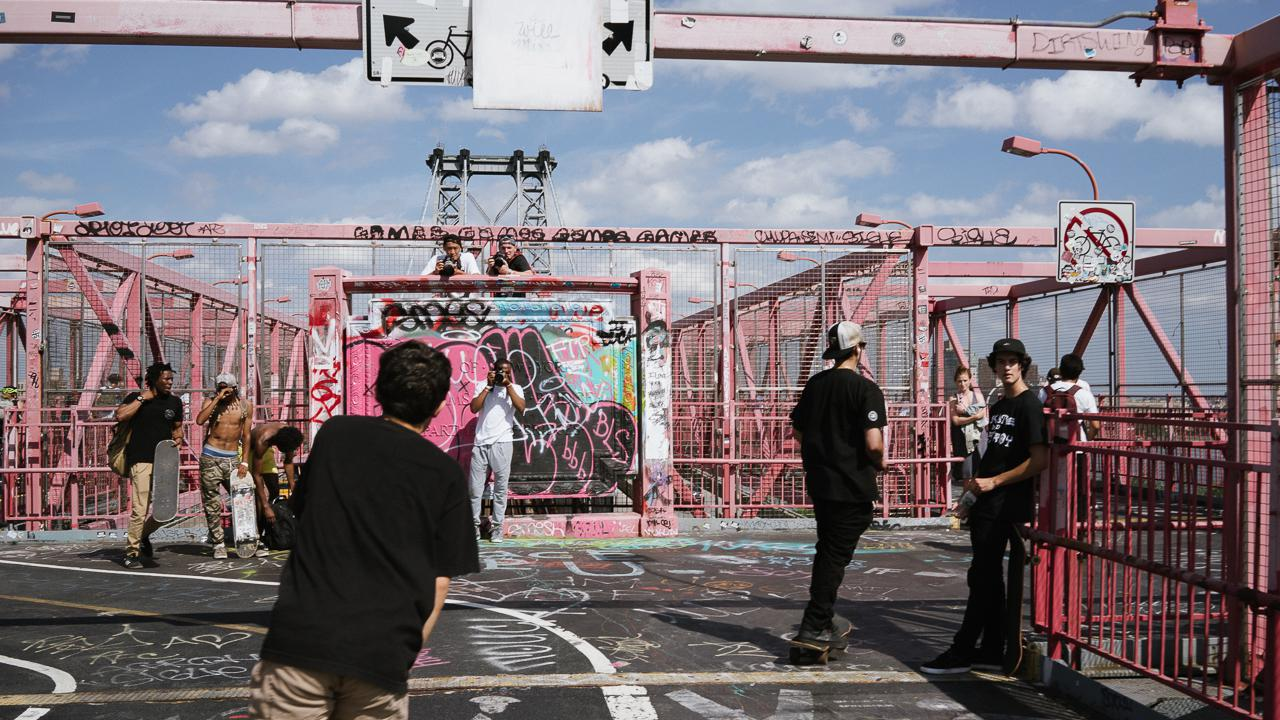

In [34]:
img = np.float32(PIL.Image.open('overbridge.jpg'))
showarray(img)

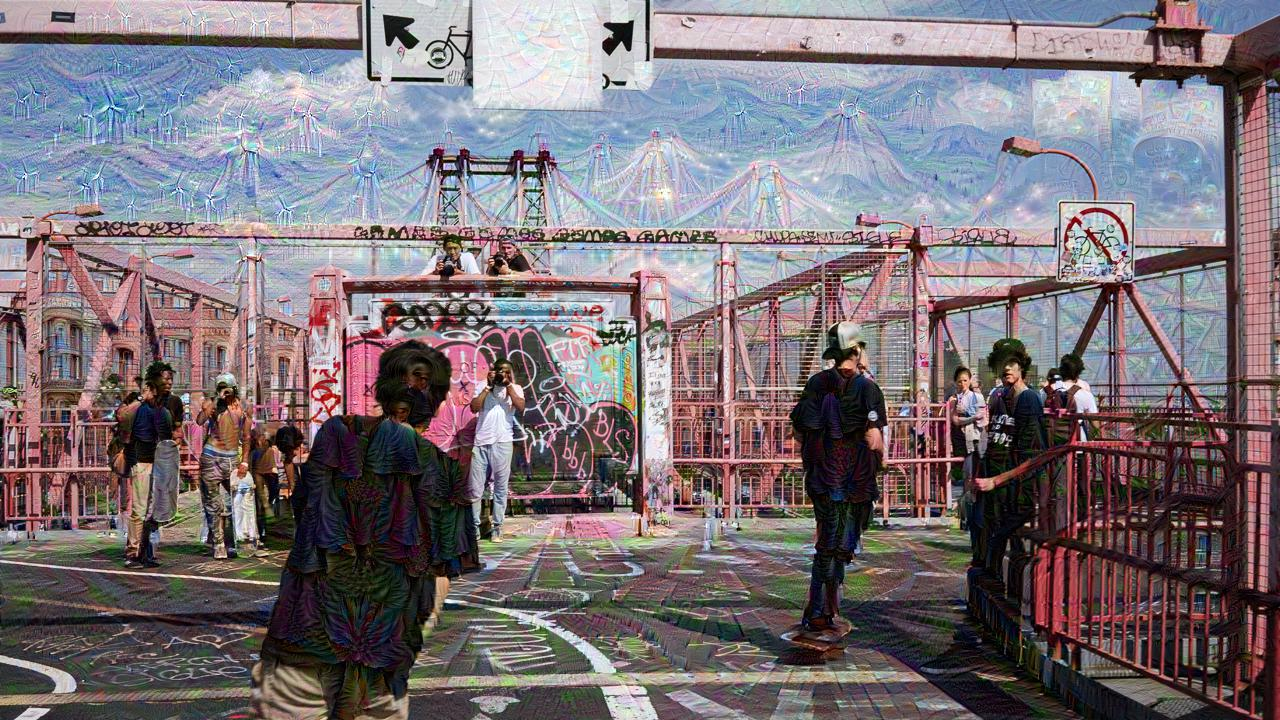

3 9 inception_4b/3x3 (720, 1280, 3)


In [35]:
# Let's start with a control, the default values
_=deepdream(net, img, end='inception_4b/3x3')

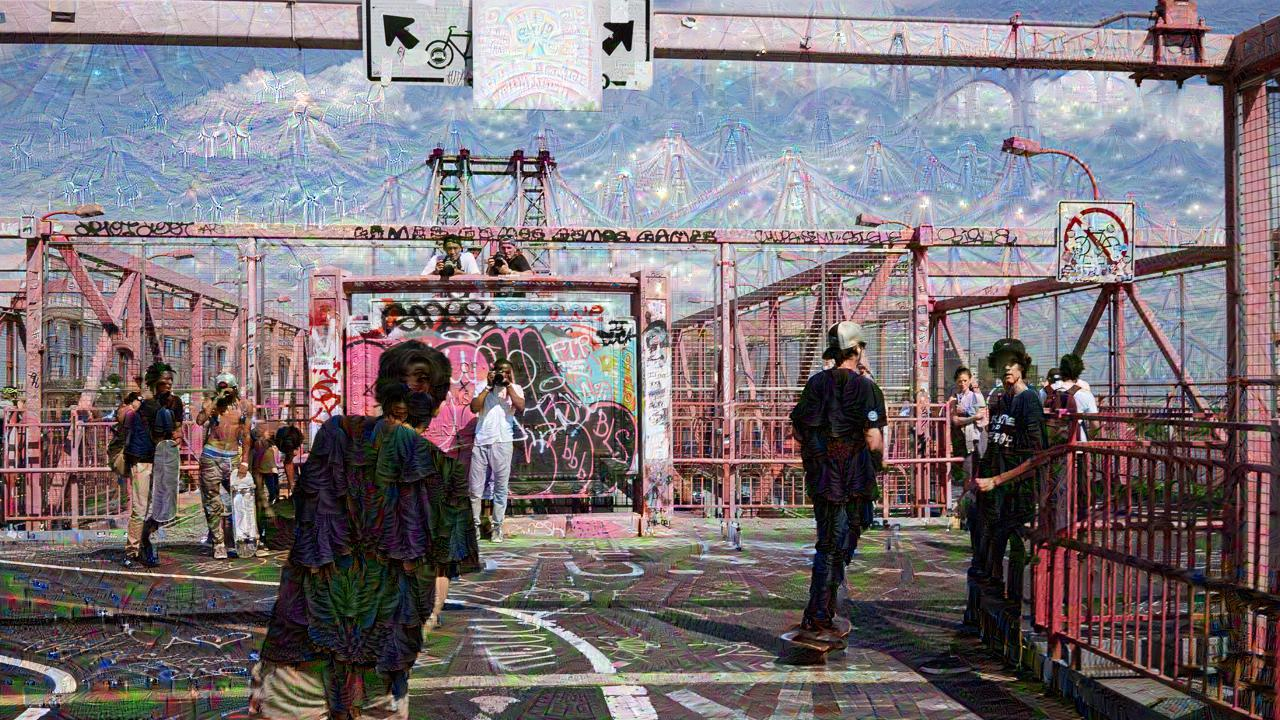

3 9 inception_4b/3x3 (720, 1280, 3)


In [46]:
# Now let's do with zero jitter:
_=deepdream(net, img, jitter=0, end='inception_4b/3x3')

Hmm. It's a bit difficult to tell, but the image done without jitter seems to have many more features, and a much more fractal nature. Let's bump up our jitter and see if that makes less features created:

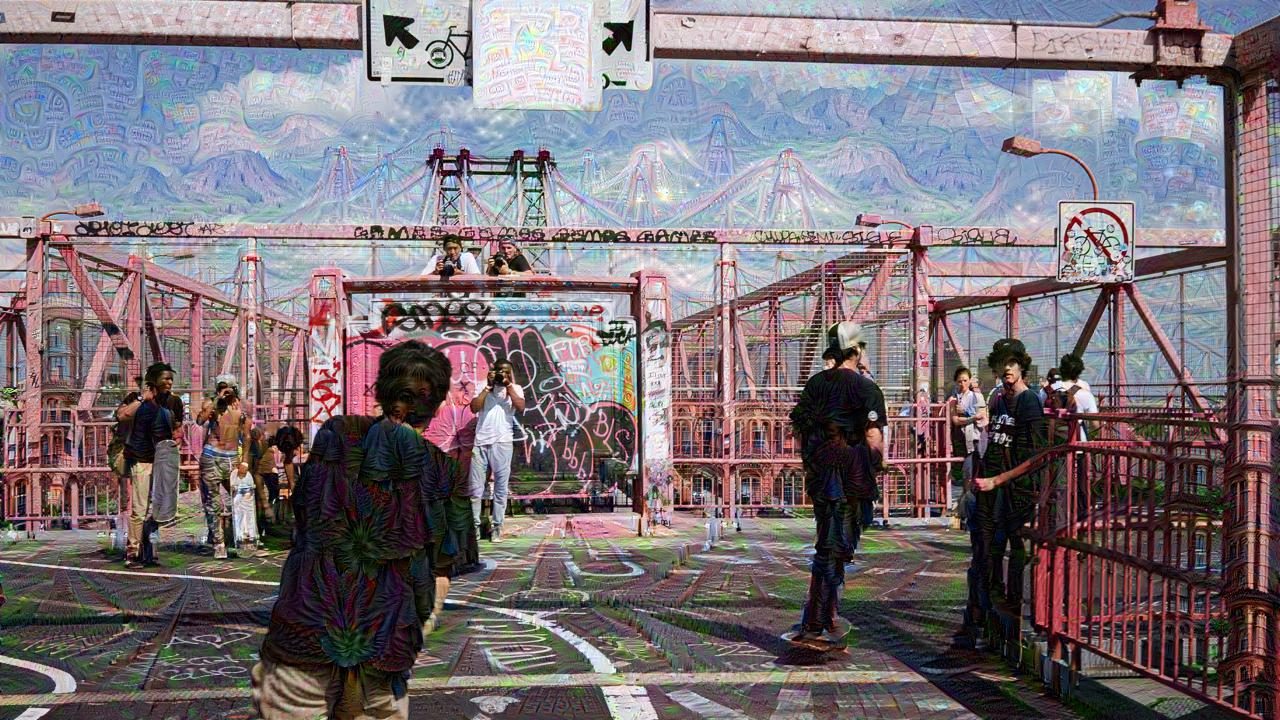

3 9 inception_4b/3x3 (720, 1280, 3)


In [37]:
# Now let's do with zero jitter:
_=deepdream(net, img, jitter=200, end='inception_4b/3x3')

Hmm, not much of a difference at the higher levels. Let's take a chance now, to look at all the levels we can choose from in our neural network. We do this with the following:

In [47]:
net.blobs.keys()

['data',
 'conv1/7x7_s2',
 'pool1/3x3_s2',
 'pool1/norm1',
 'conv2/3x3_reduce',
 'conv2/3x3',
 'conv2/norm2',
 'pool2/3x3_s2',
 'pool2/3x3_s2_pool2/3x3_s2_0_split_0',
 'pool2/3x3_s2_pool2/3x3_s2_0_split_1',
 'pool2/3x3_s2_pool2/3x3_s2_0_split_2',
 'pool2/3x3_s2_pool2/3x3_s2_0_split_3',
 'inception_3a/1x1',
 'inception_3a/3x3_reduce',
 'inception_3a/3x3',
 'inception_3a/5x5_reduce',
 'inception_3a/5x5',
 'inception_3a/pool',
 'inception_3a/pool_proj',
 'inception_3a/output',
 'inception_3a/output_inception_3a/output_0_split_0',
 'inception_3a/output_inception_3a/output_0_split_1',
 'inception_3a/output_inception_3a/output_0_split_2',
 'inception_3a/output_inception_3a/output_0_split_3',
 'inception_3b/1x1',
 'inception_3b/3x3_reduce',
 'inception_3b/3x3',
 'inception_3b/5x5_reduce',
 'inception_3b/5x5',
 'inception_3b/pool',
 'inception_3b/pool_proj',
 'inception_3b/output',
 'pool3/3x3_s2',
 'pool3/3x3_s2_pool3/3x3_s2_0_split_0',
 'pool3/3x3_s2_pool3/3x3_s2_0_split_1',
 'pool3/3x3_s2_p

Let's see whether or not a higher level gives us more of a difference in what the jitter offset does. Again, we'll start with a control, what Google provided by default:

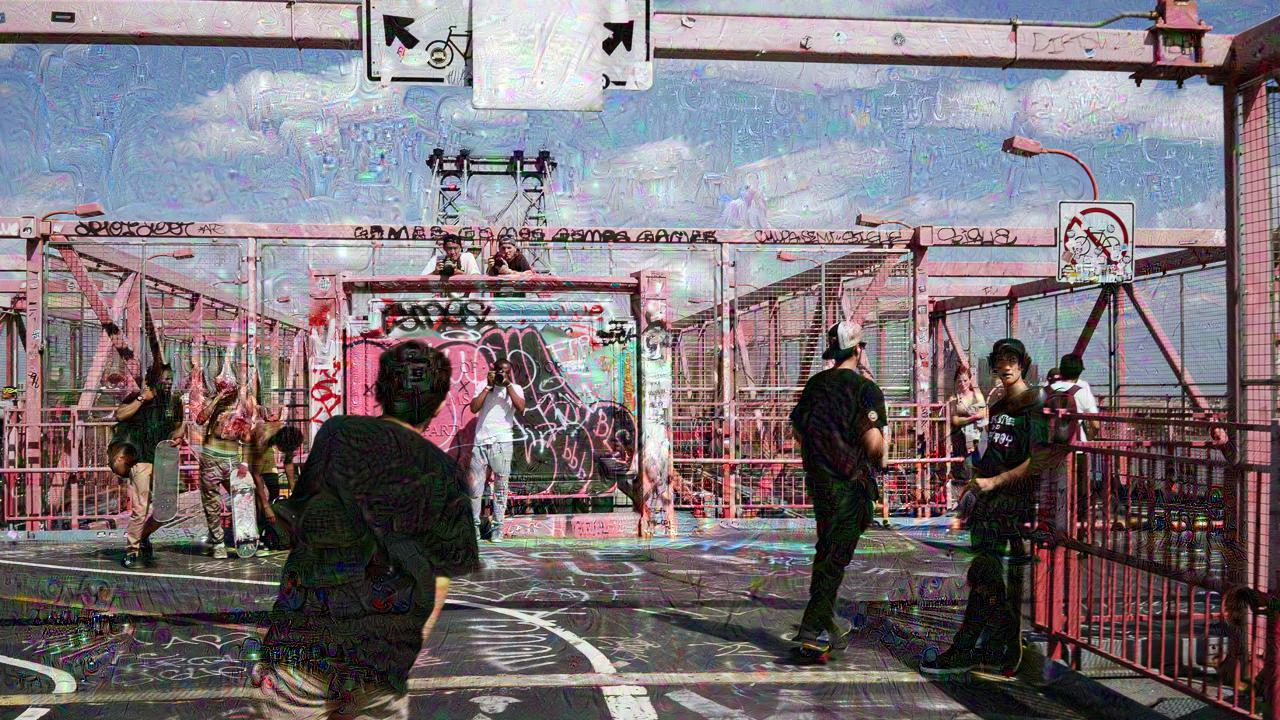

3 9 inception_5b/output (720, 1280, 3)


In [48]:
_ = deepdream(net, img, end='inception_5b/output')

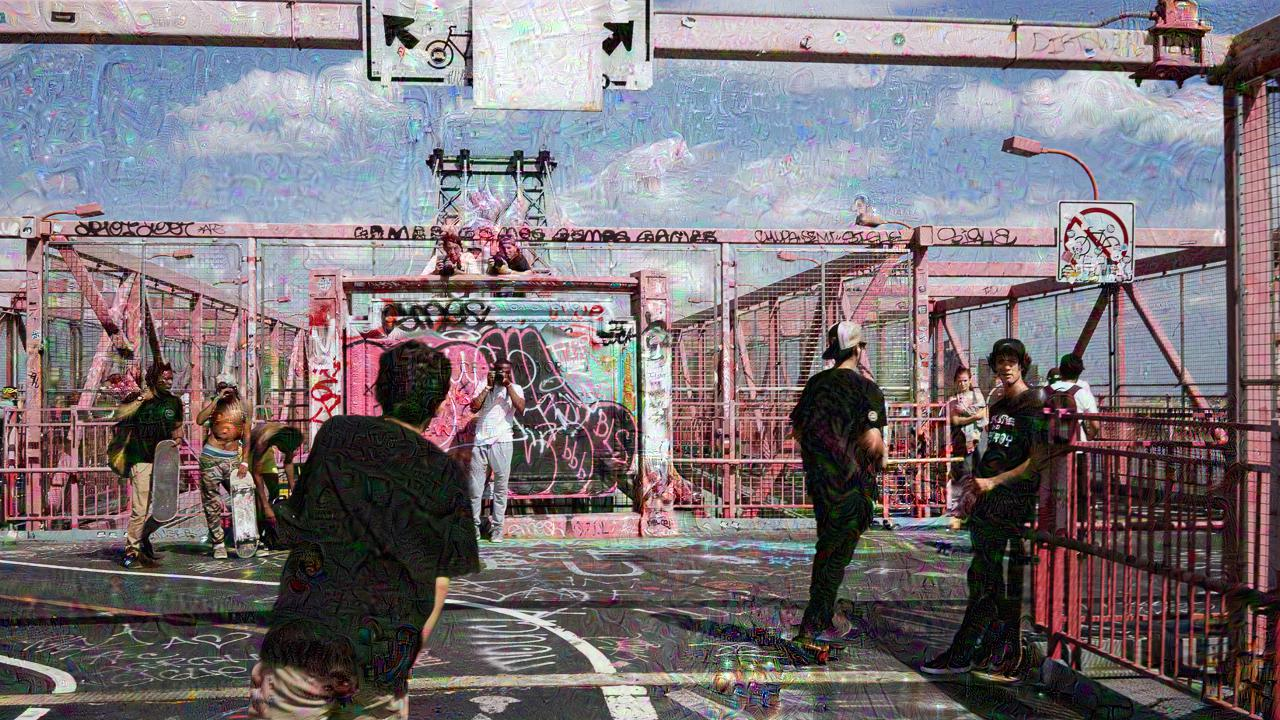

3 9 inception_5b/output (720, 1280, 3)


In [49]:
# And now, with no jitter
_ = deepdream(net, img, jitter=0, end='inception_5b/output')

Interesting, there's definitely some stronger clustering happening on the bottom of the foreground's shirt, and on the street next to him. 

Also, the photographers in the center have stronger clusters in between them. Let's try a few loops now:

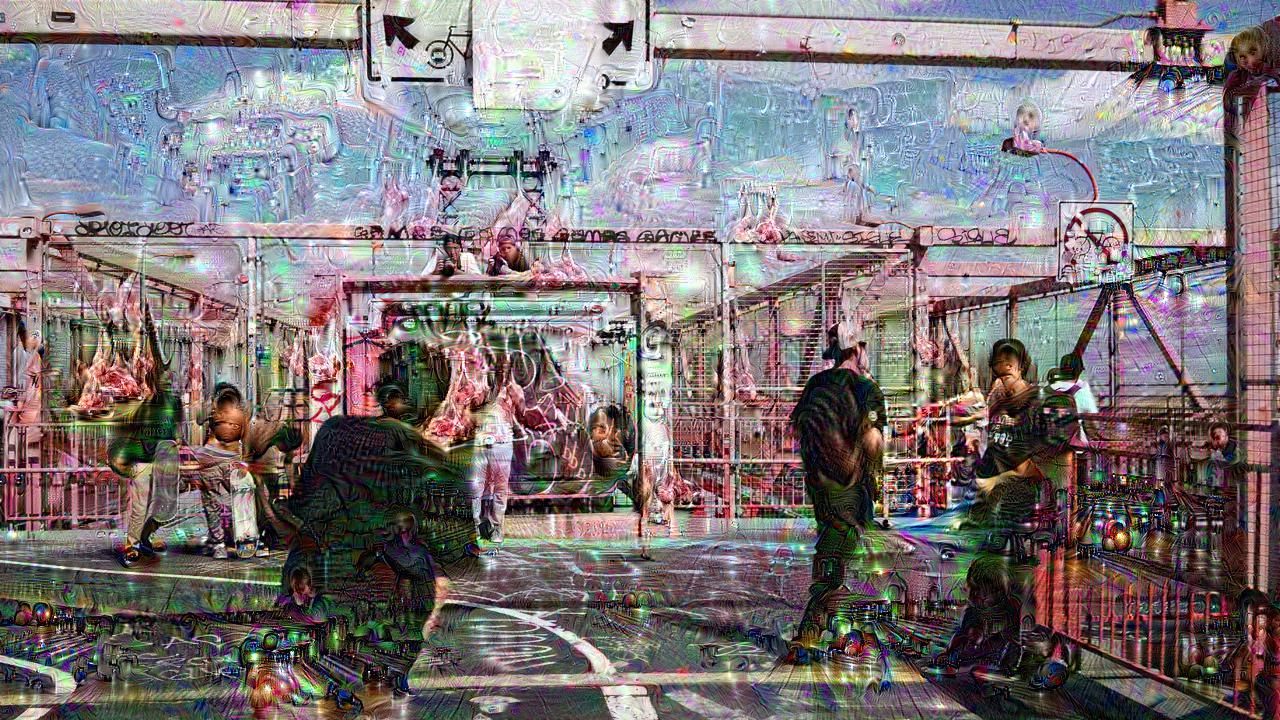

3 9 inception_5b/output (720, 1280, 3)


In [50]:
_ = deepdream(net, img, end='inception_5b/output')
for i in xrange(4):
    _ = deepdream(net, _, end='inception_5b/output')

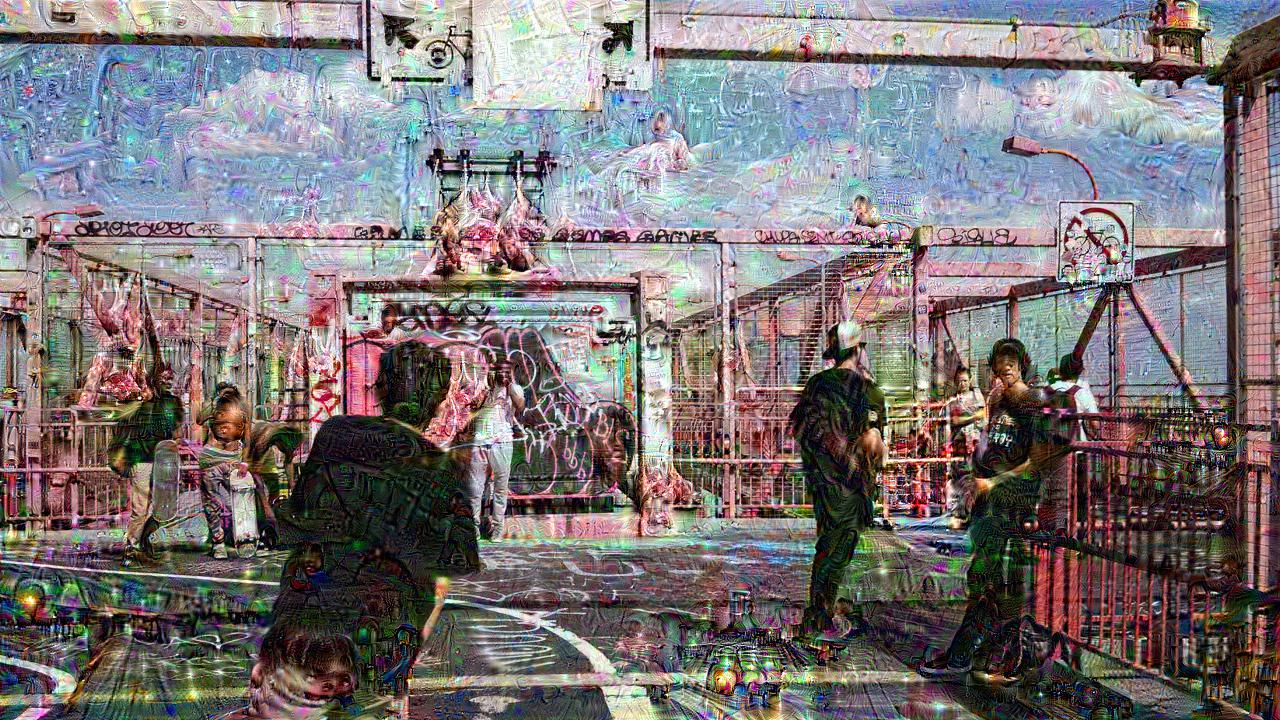

3 9 inception_5b/output (720, 1280, 3)


In [52]:
# Now with no jitter
_ = deepdream(net, img, jitter=0, end='inception_5b/output')
for i in xrange(4):
    _ = deepdream(net, _, jitter=0, end='inception_5b/output')

Not really much of a difference between the jittered and non-jittered images, other than the higher level of detail on the non-jittered images. Maybe this is a little less pleasing aesthetically, maybe not.

## Controlling Dreams

A few days after releasing Deep Dream, Google released some code to allow for controlling the Deep Dream process. This addition allows you to specify patterns the Dreams should be looking for, or what to dream about. Let's just follow up with the code, and an example:

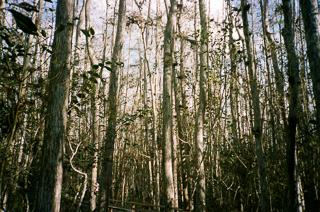

In [53]:
guide = np.float32(PIL.Image.open('swamp.jpg')) # Guide must be 320x240 pixels or below!
showarray(guide)

In [54]:
end = 'inception_4b/3x3'
h, w = guide.shape[:2]
src, dst = net.blobs['data'], net.blobs[end]
src.reshape(1,3,h,w)
src.data[0] = preprocess(net, guide)
net.forward(end=end)
guide_features = dst.data[0].copy()

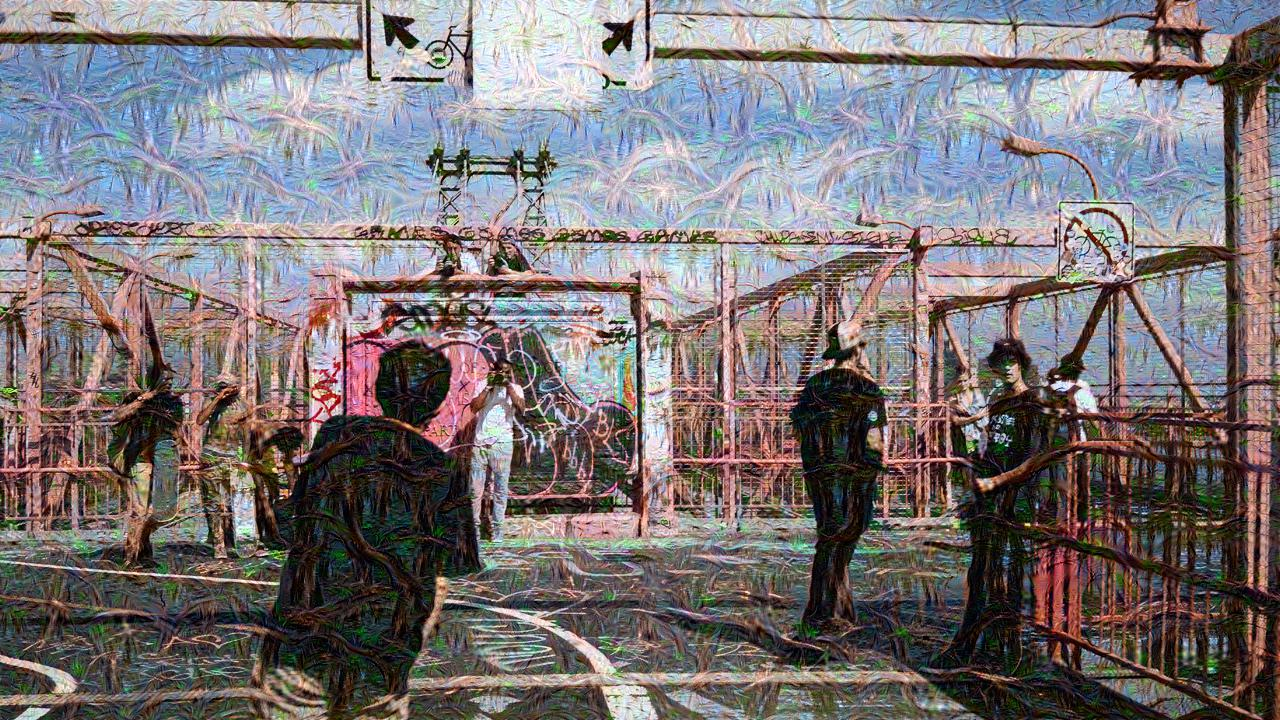

3 9 inception_4b/3x3 (720, 1280, 3)


In [56]:
def objective_guide(dst):
    x = dst.data[0].copy()
    y = guide_features
    ch = x.shape[0]
    x = x.reshape(ch,-1)
    y = y.reshape(ch,-1)
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    dst.diff[0].reshape(ch,-1)[:] = y[:,A.argmax(1)] # select ones that match best

frame = img
frame_i = 0
h, w = frame.shape[:2]
s = 0.05 # scale coefficient
_ = deepdream(net, img, objective=objective_guide, end=end)
_ = deepdream(net, _, objective=objective_guide, end=end)

As you can tell, the controlled dream really seems to pick out a specific pattern, and look for that set in all of its  processing.

## Diving into Video Processing

Creating videos of Deep Dreaming is fairly straightforward. First, you take your source video, and you render it out into a series of images. This is super easy to do with ffmpeg. In fact, it's a one liner:

$ ffmpeg -i input.mp4 %05d.jpg

This command tells ffmpeg to take your input, and create a series of images, with 5 zeros of padding. You can adjust this number if you've got extremely long video input, to make sure it all fits.

After this, do something like this:

$ mkdir output

And then run every image through the deep dream, with a bit of Python code like the following. You'll need to have your functions from above included in this file in order to have it work:

In [ ]:
import glob    # used to get list of all jpegs in directory
import timeit  # used to time how long it's gonna take

start_time = timeit.default_timer() # start the timer before we start

num_files = 0
for filename in glob.glob('*.jpg'):
    img = np.float32(PIL.Image.open(filename))   # open the first image
    print 'Starting with ' + filename
    frame = deepdream(net, img, end=end, objective=objective_guide) # deep dream it, this is using guided.
    PIL.Image.fromarray(np.uint8(frame)).save('output/' + filename) # Save it
    num_files += 1                               # increment file counter

elapsed = timeit.default_timer() - start_time
print "Ran through " + str(num_files) + " in " + str(elapsed) + "seconds. " + str(elapsed / num_files) + " seconds per image average."

Finally, to convert our image sequence back into a video, we do the ffmpeg command in reverse:

$ ffmpeg -i %05d.jpg out.mp4

Easy!

## Where to go from here

I encourage you to just experiment and play. Deep dream has been a great way to expose more people to machine learning, but also to expose everyone to the great potential of creative computation. What ways can we make our computational experience a more human experience? I think getting this glimpse into what machines see gives us a bit of empathy for what may be going on inside of the machines we use every day.

That being said, what can we do with this? Where can we go with these sorts of algorithms?

### Creating Video Effects

Adding things like optical flow and masking, and training with our own datasets, we could have videos which pick out and create effects never seen before. Everything turning into brush strokes, everything turning into trees, and if you choose an image sequence for your control, what then? Experiment and find out. And then share what you've made.

### Training your own network

Getting the dataset together seems to mostly be something that large commercial and educational institutions are only capable of. But we've got the power of computation behind us. How can you build a dataset using scraped or existing data you've already got?

### Moving to Three Dimensions

Maybe you've got a dataset of 3D objects you can find somewhere. What does a built network for recognizing 3D objects look like? 

### Using Games as Datasets

Can you write a script to get a large amount of labeled data out of a game? What does that look like?

### Dreaming in Audio

Using MFCCs, or their equivelant, build up a labeled dataset, and go wild.